### Load modules

In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import random as rnd
import time

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax

# PyTorch
import torch
import torch.utils.data as data

# check versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

# import priors 
#from models.priors import *

# import functions to load data
from priorCVAE.models.data import *

# import VAE architecture
from priorCVAE.models.cvae import *

# import loss functions
from priorCVAE.models.losses import *

# Test dist_euclid
#x1 = jnp.array([1,2,3])
#dist_euclid(x1,x1)

# test kl_divergence
#x1 = jnp.array([1.1,2,3])
#kl = kl_divergence(x1, x1)
#kl

/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


Pytorch version:  1.12.1
Numpyro version:  0.11.0
JAX version:      0.4.12
Flax version:     0.6.1
Optax version:    0.1.4
Pythorch version: 3.10.11


In [2]:
# test architecture using test_architecture.py

### Setup arguments

In [3]:
args = {"seed": 0,
        
        # data
        "num_samples": 10000,
        
        # architecture
        "conditional": False,   # CVAE if True, VAE otherwise
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,
       }

### Generate data


In [4]:


train_set = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=42)  
val_set   = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=43)  
test_set  = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=44)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=args["batch_size"])

# these lines are VERY slow and produce MANY warnings - consider removing them
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

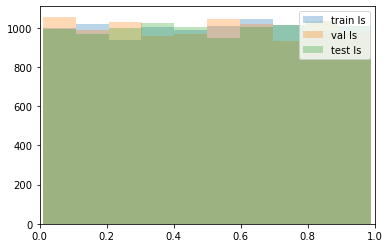

In [5]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.hist(ls_train_set, alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set,   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set,  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()

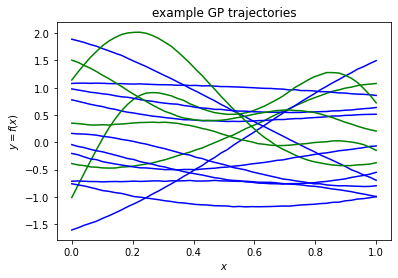

In [6]:
# check: what trajectories are we generating?

fig, ax = plt.subplots()
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [7]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
conditional = args["conditional"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]
num_epochs  = args["num_epochs"]

### Training loop

In [8]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y) 
        rcl_loss = rcl(y_hat, y).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads), loss_fn(state.params)

In [9]:
@jax.jit
def eval(state, batch):
    def loss_fn(params):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y) 
        rcl_loss = rcl(y_hat, y).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    return loss_fn(state.params)

[    1] training loss: 1553.070
[   11] training loss: 386.838
[   21] training loss: 270.392
[   31] training loss: 185.875
[   41] training loss: 202.622
[   51] training loss: 173.779
[   61] training loss: 125.761
[   71] training loss: 155.450
[   81] training loss: 178.861
[   91] training loss: 148.784
[  101] training loss: 252.789
[  111] training loss: 142.359
[  121] training loss: 130.289
[  131] training loss: 109.896
[  141] training loss: 77.755
[  151] training loss: 124.146
[  161] training loss: 105.855
[  171] training loss: 154.171
[  181] training loss: 120.291
[  191] training loss: 152.714
Training of 200 epochs took 17 seconds


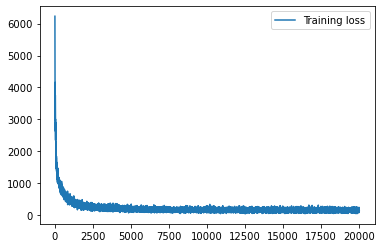

In [10]:
# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(key, y)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

# check architecture
#print(model.tabulate(key, train_set.y,
#      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

_loss_train = []

t_start = time.time()

for epoch in range(num_epochs):
    for _, batch_train in enumerate(train_loader):
        state, loss_train = train_step(state, batch_train)
        _loss_train.append(loss_train)

    if epoch % 10 == 0:    # print every 10 epochs
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of {num_epochs} epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_samples // batch_size

plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.legend()



/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    1] training loss: 1675.845, test loss: 1879.162


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    2] training loss: 1106.430, test loss: 1380.896


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    3] training loss: 988.425, test loss: 1149.670


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    4] training loss: 898.285, test loss: 1002.081


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    5] training loss: 933.361, test loss: 894.238


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    6] training loss: 651.536, test loss: 822.507


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    7] training loss: 733.046, test loss: 752.172


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    8] training loss: 588.110, test loss: 698.162


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[    9] training loss: 599.383, test loss: 654.912


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   10] training loss: 536.161, test loss: 605.330


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   11] training loss: 478.053, test loss: 572.861


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   12] training loss: 427.931, test loss: 544.013


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   13] training loss: 333.164, test loss: 520.199


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   14] training loss: 329.196, test loss: 502.824


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   15] training loss: 375.926, test loss: 487.004


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   16] training loss: 346.432, test loss: 468.186


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   17] training loss: 221.383, test loss: 452.932


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   18] training loss: 349.149, test loss: 436.819


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   19] training loss: 213.186, test loss: 429.360


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   20] training loss: 235.487, test loss: 412.505


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   21] training loss: 359.948, test loss: 402.516


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   22] training loss: 212.019, test loss: 396.254


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   23] training loss: 214.480, test loss: 383.810


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   24] training loss: 221.778, test loss: 375.079


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   25] training loss: 152.437, test loss: 366.882


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   26] training loss: 181.724, test loss: 364.944


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   27] training loss: 166.712, test loss: 359.794


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   28] training loss: 227.542, test loss: 360.174


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   29] training loss: 315.570, test loss: 352.965


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   30] training loss: 190.975, test loss: 347.692


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   31] training loss: 252.086, test loss: 343.199


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   32] training loss: 209.433, test loss: 343.029


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   33] training loss: 166.478, test loss: 340.275


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   34] training loss: 230.322, test loss: 335.407


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   35] training loss: 284.940, test loss: 331.609


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   36] training loss: 191.624, test loss: 330.769


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   37] training loss: 128.195, test loss: 328.614


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   38] training loss: 173.236, test loss: 329.927


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   39] training loss: 210.299, test loss: 325.324


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   40] training loss: 197.963, test loss: 323.319


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   41] training loss: 246.904, test loss: 320.223


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   42] training loss: 161.883, test loss: 318.200


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   43] training loss: 165.620, test loss: 314.834


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   44] training loss: 119.189, test loss: 314.995


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   45] training loss: 105.883, test loss: 313.441


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   46] training loss: 208.035, test loss: 313.999


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   47] training loss: 179.316, test loss: 310.576


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   48] training loss: 187.765, test loss: 309.641


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   49] training loss: 233.065, test loss: 307.644


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   50] training loss: 121.042, test loss: 307.166


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   51] training loss: 186.108, test loss: 295.778


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   52] training loss: 230.614, test loss: 297.117


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   53] training loss: 247.744, test loss: 294.040


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   54] training loss: 169.207, test loss: 294.133


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   55] training loss: 141.574, test loss: 292.753


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   56] training loss: 223.946, test loss: 287.740


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   57] training loss: 156.412, test loss: 288.033


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   58] training loss: 162.925, test loss: 287.591


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   59] training loss: 203.449, test loss: 285.539


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   60] training loss: 178.611, test loss: 282.087


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   61] training loss: 149.598, test loss: 281.986


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   62] training loss: 128.771, test loss: 281.658


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   63] training loss: 202.887, test loss: 281.143


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   64] training loss: 115.839, test loss: 281.428


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   65] training loss: 143.009, test loss: 275.849


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   66] training loss: 167.730, test loss: 278.260


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   67] training loss: 187.695, test loss: 276.603


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   68] training loss: 197.631, test loss: 272.820


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   69] training loss: 195.923, test loss: 273.913


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   70] training loss: 153.975, test loss: 274.875


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   71] training loss: 148.652, test loss: 270.420


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   72] training loss: 156.618, test loss: 274.070


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   73] training loss: 189.007, test loss: 268.662


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   74] training loss: 121.981, test loss: 273.518


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   75] training loss: 176.766, test loss: 267.743


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   76] training loss: 120.086, test loss: 270.082


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   77] training loss: 220.810, test loss: 271.790


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   78] training loss: 194.261, test loss: 271.118


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   79] training loss: 195.195, test loss: 268.102


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   80] training loss: 94.948, test loss: 267.239


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   81] training loss: 148.813, test loss: 269.746


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   82] training loss: 174.311, test loss: 268.059


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   83] training loss: 204.076, test loss: 266.373


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   84] training loss: 191.263, test loss: 265.976


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   85] training loss: 122.570, test loss: 266.152


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   86] training loss: 200.228, test loss: 266.527


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   87] training loss: 172.297, test loss: 266.722


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   88] training loss: 116.612, test loss: 264.173


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   89] training loss: 121.229, test loss: 261.441


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   90] training loss: 164.517, test loss: 266.489


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   91] training loss: 92.554, test loss: 265.322


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   92] training loss: 148.925, test loss: 265.116


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   93] training loss: 168.531, test loss: 264.514


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   94] training loss: 126.233, test loss: 263.835


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   95] training loss: 98.350, test loss: 262.648


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   96] training loss: 254.424, test loss: 262.135


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   97] training loss: 284.440, test loss: 262.184


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   98] training loss: 180.839, test loss: 260.509


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[   99] training loss: 75.992, test loss: 258.924


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  100] training loss: 111.810, test loss: 263.161


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  101] training loss: 135.525, test loss: 262.068


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  102] training loss: 156.227, test loss: 260.747


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  103] training loss: 164.141, test loss: 261.138


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  104] training loss: 210.675, test loss: 263.159


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  105] training loss: 197.840, test loss: 260.060


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  106] training loss: 70.585, test loss: 262.237


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  107] training loss: 119.220, test loss: 259.447


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  108] training loss: 175.359, test loss: 260.127


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  109] training loss: 269.854, test loss: 259.641


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  110] training loss: 132.519, test loss: 262.182


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  111] training loss: 114.057, test loss: 256.987


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  112] training loss: 104.682, test loss: 255.888


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  113] training loss: 138.304, test loss: 259.756


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  114] training loss: 147.058, test loss: 257.765


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  115] training loss: 221.241, test loss: 258.004


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  116] training loss: 138.386, test loss: 257.172


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  117] training loss: 190.759, test loss: 259.671


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  118] training loss: 139.840, test loss: 255.658


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  119] training loss: 175.449, test loss: 257.447


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  120] training loss: 143.455, test loss: 257.760


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  121] training loss: 96.574, test loss: 258.448


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  122] training loss: 139.906, test loss: 257.715


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  123] training loss: 86.749, test loss: 256.408


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  124] training loss: 137.262, test loss: 257.217


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  125] training loss: 100.845, test loss: 254.625


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  126] training loss: 152.755, test loss: 257.468


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  127] training loss: 123.475, test loss: 255.294


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  128] training loss: 162.140, test loss: 255.494


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  129] training loss: 172.019, test loss: 255.585


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  130] training loss: 197.505, test loss: 259.898


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  131] training loss: 104.143, test loss: 255.006


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  132] training loss: 157.501, test loss: 256.075


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  133] training loss: 187.319, test loss: 255.088


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  134] training loss: 221.390, test loss: 256.550


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  135] training loss: 197.416, test loss: 254.120


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  136] training loss: 147.394, test loss: 255.352


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  137] training loss: 94.744, test loss: 254.659


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  138] training loss: 111.043, test loss: 257.274


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  139] training loss: 141.609, test loss: 255.624


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  140] training loss: 154.544, test loss: 253.411


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  141] training loss: 81.833, test loss: 251.873


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  142] training loss: 109.409, test loss: 256.736


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  143] training loss: 83.702, test loss: 256.297


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  144] training loss: 203.502, test loss: 256.943


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  145] training loss: 125.332, test loss: 255.021


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  146] training loss: 192.219, test loss: 254.028


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  147] training loss: 209.976, test loss: 252.710


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  148] training loss: 170.393, test loss: 252.879


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  149] training loss: 159.244, test loss: 252.216


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  150] training loss: 134.315, test loss: 252.434


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  151] training loss: 209.251, test loss: 253.279


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  152] training loss: 72.507, test loss: 254.273


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  153] training loss: 148.461, test loss: 253.091


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  154] training loss: 106.429, test loss: 254.641


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  155] training loss: 93.794, test loss: 251.561


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  156] training loss: 92.246, test loss: 253.415


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  157] training loss: 160.078, test loss: 252.388


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  158] training loss: 250.377, test loss: 252.083


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  159] training loss: 115.162, test loss: 254.598


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  160] training loss: 130.783, test loss: 253.647


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  161] training loss: 115.785, test loss: 254.893


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  162] training loss: 141.365, test loss: 251.656


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  163] training loss: 150.239, test loss: 251.332


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  164] training loss: 193.244, test loss: 256.111


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  165] training loss: 128.855, test loss: 253.164


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  166] training loss: 171.860, test loss: 253.267


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  167] training loss: 138.352, test loss: 250.575


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  168] training loss: 137.547, test loss: 252.415


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  169] training loss: 163.687, test loss: 255.132


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  170] training loss: 130.973, test loss: 251.524


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  171] training loss: 140.760, test loss: 251.139


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  172] training loss: 209.160, test loss: 250.906


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  173] training loss: 154.884, test loss: 250.433


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  174] training loss: 204.480, test loss: 250.883


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  175] training loss: 123.876, test loss: 252.456


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  176] training loss: 115.078, test loss: 253.310


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  177] training loss: 123.965, test loss: 252.132


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  178] training loss: 135.421, test loss: 249.645


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  179] training loss: 120.959, test loss: 249.534


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  180] training loss: 84.567, test loss: 250.374


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  181] training loss: 130.193, test loss: 251.056


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  182] training loss: 163.929, test loss: 249.359


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  183] training loss: 107.973, test loss: 251.637


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  184] training loss: 100.296, test loss: 250.311


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  185] training loss: 199.175, test loss: 250.285


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  186] training loss: 116.656, test loss: 248.838


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  187] training loss: 192.918, test loss: 251.226


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  188] training loss: 84.281, test loss: 247.455


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  189] training loss: 111.468, test loss: 252.543


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  190] training loss: 163.865, test loss: 252.685


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  191] training loss: 177.770, test loss: 249.419


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  192] training loss: 77.643, test loss: 249.015


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  193] training loss: 172.767, test loss: 249.857


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  194] training loss: 163.264, test loss: 250.314


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  195] training loss: 144.673, test loss: 249.068


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  196] training loss: 101.387, test loss: 247.914


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  197] training loss: 205.363, test loss: 250.569


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  198] training loss: 77.374, test loss: 248.839


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  199] training loss: 226.040, test loss: 250.723


/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths 

[  200] training loss: 103.704, test loss: 251.929
Training of 10 epochs took 3038 seconds


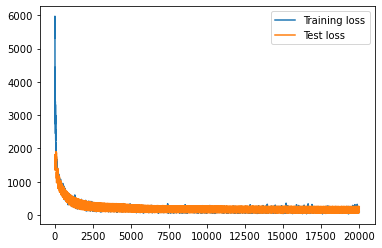

In [11]:
# WHY is this cell so much slower than the previous one?

# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(key, y)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

# check architecture
#print(model.tabulate(key, train_set.y,
#      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

_loss_train = []
_loss_test = []

t_start = time.time()

for epoch in range(num_epochs):
    # Training phase
    for _, batch_train in enumerate(train_loader):
        state, loss_train = train_step(state, batch_train)
        _loss_train.append(loss_train)

    # Test phase
    for _, batch_test in enumerate(test_loader):
        loss_test = eval(state, batch_test)
        _loss_test.append(loss_test)

    if epoch % 1 == 0:    # print every 10 epochs
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}, test loss: {loss_test:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of 10 epochs took {round(t_elapsed)} seconds')

#assert len(_loss_train) == num_epochs * num_samples // batch_size

plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.plot(range(len(_loss_test)), _loss_test, label = 'Test loss')
plt.legend()